# Variational Auto-Encoder

## 0. Initialize

In [1]:
#mathematics
using Zygote
using Flux
using LinearAlgebra

#statistics
using Random
using Statistics
using Distributions

#dataset
using MLDatasets

#visualize
using Images
using Plots
pyplot()

#macros
using ProgressMeter
using UnPack

ProgressMeter.ijulia_behavior(:clear)

false

## 1. Define the model and functions

In [2]:
#vectorize image data
function vectorize_images(X_train)
    #d:dimension, N:train sample size
    d,d,N = size(X_train)

    #vectorize the image
    X = zeros(d*d,N)
    @showprogress for n in 1:N
        X[:,n] = X_train[:,:,n][:]
    end
    return X,N,d*d
end

#create decoder and encoder
function create_NN(z_dim,n_hidden,x_dim)
    #decoder
    decoder = Chain(
        Dense(0.1*randn(n_hidden,z_dim),zeros(n_hidden),tanh),
    )
    x_mean_decoder = Chain(decoder,Dense(0.1*randn(x_dim,n_hidden),zeros(x_dim)))
    
    #encoder 
    encoder = Chain(
        Dense(0.1*randn(n_hidden,x_dim),zeros(n_hidden),tanh),
    )
    z_mean_encoder = Chain(encoder,Dense(0.1*randn(z_dim,n_hidden),zeros(z_dim)))
    z_logstd_encoder = Chain(encoder,Dense(0.1*randn(z_dim,n_hidden),zeros(z_dim)))
    return x_mean_decoder,z_mean_encoder,z_logstd_encoder
end

#reparametrize
function reparametrize(z_mean,z_logstd,z_dim)
    z_mean + exp.(z_logstd) .* randn(z_dim)
end

#KL divergence between variational posterior and prior
function KL_var_prior(z_mean,z_logstd,z_dim)
    0.5f0 * sum(@. (exp(2f0*z_logstd) + z_mean^2f0 - 2f0*z_logstd - 1f0))
end

#negative reconstruction error
function neg_reconst_error(xn,x_mean)
    logpdf(MvNormal(x_mean,1),xn)
end

#ELBO 
function ELBO_minibatch(
        x_mean_decoder,z_mean_encoder,z_logstd_encoder,
        X_minibatch,N,z_dim,minibatch_size
    )
    
    #encode
    z_means,z_logstds = z_mean_encoder(X_minibatch),z_logstd_encoder(X_minibatch)
    zs = reparametrize(z_means,z_logstds,z_dim)
    
    #compute ELBO
    L = neg_reconst_error(X_minibatch[:],x_mean_decoder(zs)[:])
    L -= KL_var_prior(z_means,z_logstds,z_dim)
    return N*L/minibatch_size
end

#create VAE model
function create_model(X,z_dim,n_hidden,x_dim,minibatch_size)
    x_mean_decoder,z_mean_encoder,z_logstd_encoder = create_NN(z_dim,n_hidden,x_dim)
    loss_func = (
        M -> -ELBO_minibatch(
                x_mean_decoder,z_mean_encoder,z_logstd_encoder,M,N,z_dim,minibatch_size
            )
            + 0.01f0*sum(x->sum(x.^2), Flux.params(x_mean_decoder))   
        )
    ps = Flux.params(x_mean_decoder,z_mean_encoder,z_logstd_encoder)
    data_loader = Flux.DataLoader(X,batchsize=minibatch_size, shuffle=true, partial=false)
    return x_mean_decoder,z_mean_encoder,z_logstd_encoder,loss_func,ps,data_loader
end

#train VAE
function train_VAE(data,model_params,n_epochs,minibatch_size)
    #data and model parameters
    @unpack X,N,x_dim = data
    @unpack z_dim,n_hidden = model_params
    
    #decoder, encoder, loss function, parameters and data loader
    x_mean_decoder,z_mean_encoder,z_logstd_encoder,loss_func,ps,data_loader = create_model(
        X,z_dim,n_hidden,x_dim,minibatch_size
    )
    
    #define optimizer
    opt = ADAGrad(0.02)
    
    #ELBO for each epochs
    loss_avg = zeros(n_epochs)
    
    #train by SGD
    for k in 1:n_epochs
        #progress bar
        pb = Progress(length(data_loader), 1, "epoch $(k): ")
        
        #compute ELBO for each minibatchs
        for X_minibatch in data_loader
            loss,back = pullback(ps) do 
                loss_func(X_minibatch)
            end
            gradients = back(1f0)
            Flux.Optimise.update!(opt, ps, gradients)
            loss_avg[k] += loss
            
            #update progress bar
            next!(pb; showvalues=[(:loss, loss)])
        end
        loss_avg[k] = loss_avg[k] / length(data_loader)
    end
    NNs = [x_mean_decoder,z_mean_encoder,z_logstd_encoder]
    return NNs,ps,loss_avg
end

#return z_mean
function latent_estimate(data,model_params,NNs)
    @unpack X,N,x_dim = data
    @unpack z_dim = model_params
    z_mean_encoder = NNs[2]
    z_est = z_mean_encoder(X)
    return z_est
end

#learned manifold
function visualize_manifold(n_imgs,NNs)
    #decoder
    decoder = NNs[1]
    
    #big picture
    img_size = 28*n_imgs
    manifold = zeros(img_size,img_size)
    
    #points in latent space
    xs = range(-2,2,length=n_imgs)
    ys = range(-2,2,length=n_imgs)
    
    #decode
    for j in 1:n_imgs
        for i in 1:n_imgs
            x = xs[j]
            y = ys[i]
            manifold[28(i-1)+1:28*i, 28*(j-1)+1:28*j] = decoder([x,y])
        end
    end
    return manifold
end

#across the latent space
function across_latent_space(xs,ys,NNs)
    #decoder
    decoder = NNs[1]
    
    #decode latent representations along the line
    L = length(xs)
    imgs = zeros(28,28,L)
    for l in 1:L
        imgs[:,:,l] = decoder([xs[l],ys[l]])
    end
    return imgs
end

across_latent_space (generic function with 1 method)

## 2. Prepare MNIST data

In [3]:
#load the training data
X_train,y_train = MNIST.traindata()

#vectorize image data
X,N,x_dim = vectorize_images(X_train)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 60000, 784)

## 3. Experiment: VAE (z_dim=2)

### 3-1. Train VAE

In [4]:
#data and training parameter
data = (X=X,N=N,x_dim=x_dim)
model_params = (z_dim=2,n_hidden=500)
n_epochs = 50
minibatch_size = 100

#train VAE
@time NNs,ps,loss_avg = train_VAE(data,model_params,n_epochs,minibatch_size)

epoch 50: 100%|█████████████████████████████████████████| Time: 0:00:26
  loss:  4.463367509552762e7


1211.037878 seconds (168.73 M allocations: 1022.715 GiB, 10.11% gc time, 3.26% compilation time)


(Chain{Tuple{Chain{Tuple{Dense{typeof(tanh), Matrix{Float64}, Vector{Float64}}}}, Dense{typeof(identity), Matrix{Float64}, Vector{Float64}}}}[Chain(Chain(Dense(2, 500, tanh)), Dense(500, 784)), Chain(Chain(Dense(784, 500, tanh)), Dense(500, 2)), Chain(Chain(Dense(784, 500, tanh)), Dense(500, 2))], Params([[0.02254540913995976 -0.006206595480005617; -0.010111015756920413 0.01394149194216514; … ; 0.1545543728423856 0.07597204494775107; 0.010157520530053012 0.012937493392361402], [-0.0019607959773421417, -0.006228942661367946, 0.010308497737737116, -0.030414871557516383, 0.004872289088408563, -0.009948037596889192, 0.1560856676804245, 0.027503198106592325, -0.3502515364467049, -0.05068558283981785  …  0.061068111017654955, 0.010215350098101194, 0.023594806738516664, 0.07829560872158692, 0.016210902557797065, 0.0391622964301825, 0.1200471246283226, -0.061565494512596075, -0.0995728528648213, -0.002224539497635135], [0.15848590417882336 0.17479501727622054 … -0.20025337515910072 -0.06603418

### 3-2. Visualize the results

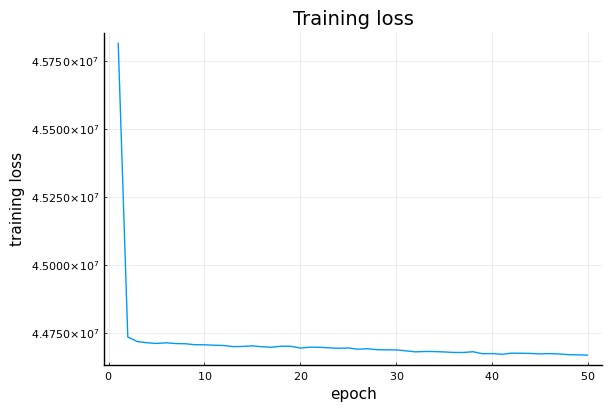

In [5]:
fig1 = plot(1:n_epochs,loss_avg,title="Training loss",xlabel="epoch",ylabel="training loss",label=false)
savefig(fig1,"figs-VAE/fig1.png")

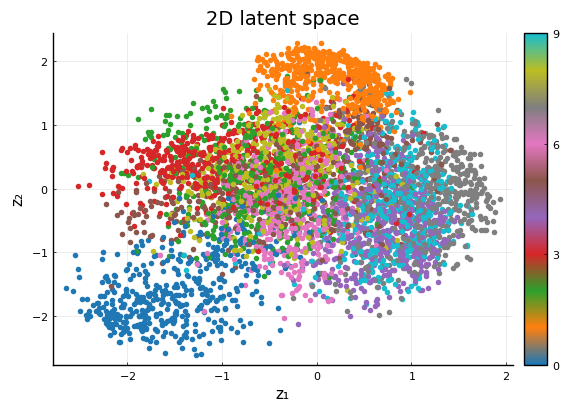

In [6]:
n_test = 5000
z_est = latent_estimate(data,model_params,NNs)
fig2 = plot(
    z_est[1,1:n_test],z_est[2,1:n_test],st=:scatter,zcolor=y_train,markerstrokewidth=0,label=false,
    xlabel="z₁", ylabel="z₂", title="2D latent space", c=palette(:tab10)
)
savefig("figs-VAE/fig2.png")

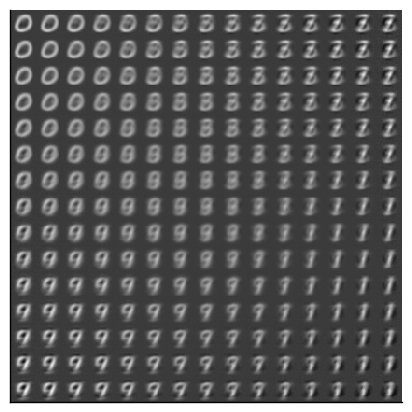

In [7]:
#learned manifold
n_imgs = 15
manifold = visualize_manifold(n_imgs,NNs)

#show the result
fig3 = plot(
    st=:heatmap,reverse(manifold',dims=1), 
    color=:grays, aspect_ratio=1, colorbar=false, xticks=false, yticks=false
    ) 
savefig(fig3,"figs-VAE/fig3.png")

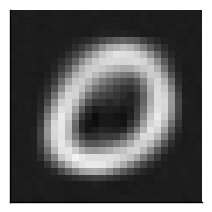

┌ Info: Saved animation to 
│   fn = /Users/kitanotomoya/Documents/julia/ML/Bayes/VAE/figs-VAE/anim1.gif
└ @ Plots /Users/kitanotomoya/.julia/packages/Plots/cPJQu/src/animation.jl:114


Plots.AnimatedGif("/Users/kitanotomoya/Documents/julia/ML/Bayes/VAE/figs-VAE/anim1.gif")
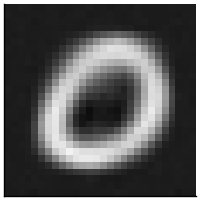

In [8]:
#a line in latent space and images
xs = -2:0.05:2
ys = @. xs^2 + xs - 4
imgs = across_latent_space(xs,ys,NNs)

#animation 1
idx = 1:length(xs)
anim1 = @animate for l in vcat(idx,reverse(idx))
    plot(
        st=:heatmap,reverse(imgs[:,:,l]',dims=1),size=(200,200),
        color=:grays,aspect_ratio=1, colorbar=false, xticks=false, yticks=false
    )
end
gif(anim1,"figs-VAE/anim1.gif")

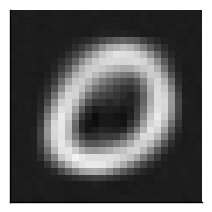

┌ Info: Saved animation to 
│   fn = /Users/kitanotomoya/Documents/julia/ML/Bayes/VAE/figs-VAE/anim2.gif
└ @ Plots /Users/kitanotomoya/.julia/packages/Plots/cPJQu/src/animation.jl:114


Plots.AnimatedGif("/Users/kitanotomoya/Documents/julia/ML/Bayes/VAE/figs-VAE/anim2.gif")
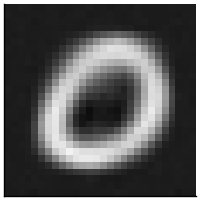

In [9]:
#a line in latent space and images
xs = -2:0.05:2
ys = xs
imgs = across_latent_space(xs,ys,NNs)

#animation 2
idx = 1:length(xs)
anim2 = @animate for l in vcat(idx,reverse(idx))
    plot(
        st=:heatmap,reverse(imgs[:,:,l]',dims=1),size=(200,200),
        color=:grays,aspect_ratio=1, colorbar=false, xticks=false, yticks=false
    )
end
gif(anim2,"figs-VAE/anim2.gif")

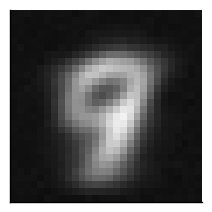

┌ Info: Saved animation to 
│   fn = /Users/kitanotomoya/Documents/julia/ML/Bayes/VAE/figs-VAE/anim3.gif
└ @ Plots /Users/kitanotomoya/.julia/packages/Plots/cPJQu/src/animation.jl:114


Plots.AnimatedGif("/Users/kitanotomoya/Documents/julia/ML/Bayes/VAE/figs-VAE/anim3.gif")
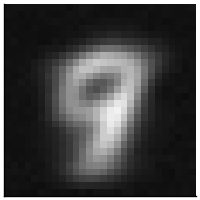

In [10]:
#a line in latent space and images
ts = 0:0.05:2*π
xs = cos.(ts)
ys = sin.(ts)
imgs = across_latent_space(xs,ys,NNs)

#animation 3
idx = 1:length(xs)
anim3 = @animate for l in 1:length(idx)
    plot(
        st=:heatmap,reverse(imgs[:,:,l]',dims=1),size=(200,200),
        color=:grays,aspect_ratio=1, colorbar=false, xticks=false, yticks=false
    )
end
gif(anim3,"figs-VAE/anim3.gif")